Autor: Jarosław Żygierewicz
# Zanim przystąpimy do ćwiczenia
W tym ćwiczeniu skorzystamy z modułu sklearn (scikit-learn) przeznaczonego do uczenia maszynowego. Zawiera wiele zoptymalizowanych i przydatnych funkcji i algorytmów. Alternatywnymi frameworkami są np. PyTorch, Tensorflow, Keras, Caffe2, chociaż z obserwacji środowiska wynika, że dominują raczej PyTorch i Tensorflow.


In [1]:
import sklearn
print('Zainstalowana wersja scikit-learn: {}.'.format(sklearn.__version__))

Zainstalowana wersja scikit-learn: 0.23.2.


Na stronie przedmiotu znajduje się instrukcja konfiguracji środowiska w przypadku pracy lokalnej, a nie w colabie. Może (nie musi) być przydatna dla osób pracujących na własnych laptopach:

https://brain.fuw.edu.pl/edu/index.php/Uczenie_maszynowe_i_sztuczne_sieci_neuronowe/konfiguracja

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

import numpy as np
from scipy import diag, interp
from itertools import cycle

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

# Ćwiczenie: Walidacja krzyżowa
Już na ostatnich ćwiczeniach przerobiliśmy walidację krzyżową. Teraz przyjrzymy się jej bliżej i sprawdźmy efekt wspomniany na wykładzie, czyli efekt częstości występowania.

* W tym ćwiczeniu przyjrzymy się jak miary jakości klasyfikatora zależą od proporcji klas w zbiorze uczącym i od rozmiaru zbioru uczącego
* Klasyfikatorem będzie nadal regresja logistyczna, ale tym razem zamiast korzystać z własnej implementacji, skorzystamy z gotowej wersji bibliotecznej z modułu [scikit-learn] (http://scikit-learn.org/stable/index.html)


Dzisiaj znowu wygenerujemy sztucznie dane, które później będziemy klasyfikować, a to po to, aby mieć pełną kontrolę nad częstością występowania klas.

Poniższa funkcja przyjmuje za argument liczbę przykładów, którą ma wygenerować.
Wygenerowane przykłady będą pochodziły z dwóch dwuwymiarowych rozkładów normalnych = klas określonych przez średnią mu[klasa] i macierz kowariancji cov[klasa]. Możemy te cechy dowolnie zmieniać.

In [3]:
def gen(ile):
    mu = [(-1,0.5),(1.2,4)] #średnie klas
    cov = [diag([3,3]), diag([4,1.7])] #macierze kowariancji dla klas
    
    X = np.zeros((ile*len(mu), 2)) # miejsce na dane wejściowe
    Y = np.zeros((ile*len(mu), 1),dtype = int) # miejsce na dane wyjściowe
    # użyj modułu np.random aby wygenerować liczby w X z rozkładu normalnego wielowymiarowego
    # Y powinno zawierać liczbowy identyfikator klasy, tj. 0, 1, 2, 3 ..
    for klasa in range(len(mu)):
        # miejsce na twój kod
        X[klasa*ile:(klasa+1)*ile] = np.random.multivariate_normal(mu[klasa],cov[klasa],ile)
        Y[klasa*ile:(klasa+1)*ile] = klasa
    # ravel spłaszczy nam Y do 1D
    Y = Y.ravel()
    return (X,Y)

Testujemy tę funkcję, generujemy 50 przykładów, pierwszych 5 wypisujemy, wszystkie rysujemy za pomocą funkcji `scatter`. Pamiętajmy, że za każdym wywołaniem funkcji będziemy dostawać różne dane (jako że są one generowane przez np.random).

<ipython-input-3-aa6fb8a36dde>:3: DeprecationWarning: scipy.diag is deprecated and will be removed in SciPy 2.0.0, use numpy.diag instead
  cov = [diag([3,3]), diag([4,1.7])] #macierze kowariancji dla klas


X:  [[-0.51744353  4.17626645]
 [-4.12508267  2.07449487]
 [ 2.11435246  0.70771154]
 [-1.70383565  1.51593513]
 [-0.6522316  -2.21405951]]
Y:  [0 0 0 0 0]


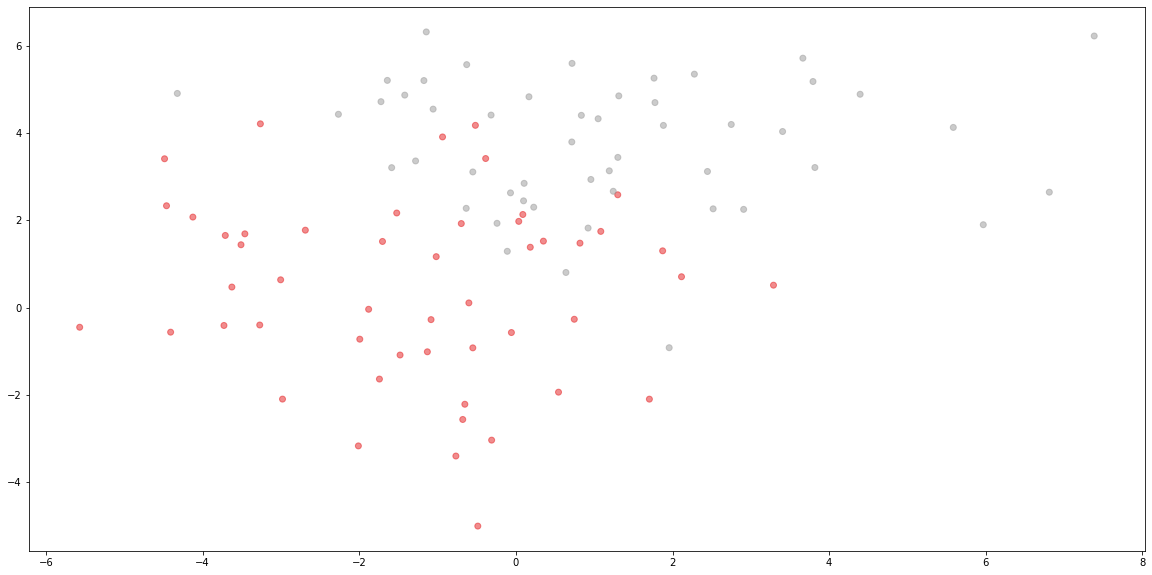

In [4]:
# miejsce na Twój kod
X,Y = gen(50)
print('X: ', X[0:5,:])
print('Y: ', Y[0:5])
plt.scatter(X[:,0], X[:,1], c = Y, cmap=plt.cm.Set1, alpha = 0.5)
plt.show()

# Klasy równoliczne

## Zaobserwujmy zmienność miar jakości klasyfikatora przy wybieraniu podzbiorów do uczenia i testowania ze zbioru uczącego.
* do podziałów zbioru zastosujemy funkcję [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
* do obliczania miar jakości zastosujemy funkcje z modułu [sklearn.metrics](http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)

Wykonaj podział zbioru uczącego tak, aby zestaw testowy stanowił 20% całego zbioru uczącego. Zilustruj za pomocą `scatter` punkty należące do części uczącej i do części testowej.

W razie wątpliwości, sprawdź funkcję w dokumentacji. Warto to robić dla wszelkich problemów, funkcje i metody z bibliotek ML są zazwyczaj dobrze opisane.

* Podział:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

* Ilustracja:

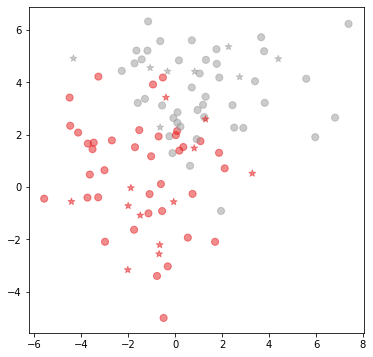

In [6]:
plt.figure(figsize=(6,6))
plt.scatter(X_train[:,0], X_train[:,1], c = y_train, cmap=plt.cm.Set1, alpha = 0.5, s=50)
plt.scatter(X_test[:,0], X_test[:,1], c = y_test, cmap=plt.cm.Set1, alpha = 0.5, marker = '*', s=50 )
plt.show()

Regresja logistyczna zaimplementowana jest w klasie [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Tworzymy instancję obiektu tej klasy. Jeśli nie ustawimy żadnego algorytmu optymalizacji, to domyślnie zostanie ustawiony solver 'lbfgs', ale jednocześnie generuje to irytujący warning, więc lepiej zadeklarować go z góry.

In [7]:
model = LogisticRegression(solver = 'lbfgs')

Uczymy go  na zbiorze uczącym (fitujemy):

In [8]:
model.fit(X_train, y_train)

LogisticRegression()

Wykonujemy predykcje dla zbioru testowego:

In [9]:
y_pred = model.predict(X_test)  

Efekty można obejrzeć za pomocą macierzy pomyłek: 

In [10]:
# użyj funkcji sklearn.metrics.confusion_matrix i wypisz wartości TN, FP, FN, TP
print(metrics.confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print('TN: ',tn,'FP: ', fp, 'FN: ', fn, 'TP: ', tp )

[[8 4]
 [2 6]]
TN:  8 FP:  4 FN:  2 TP:  6


W pętli powtórzymy proces podziału zbioru uczącego i dla każdego podziału obliczmy miary jakości:
* precyzja pozytywna: (positive predictive value (PPV), precision). Odpowiada na pytanie: "Jeśli wynik testu jest pozytywny, jakie jest prawdopodobieństwo, że osoba badana jest chora?"

$\qquad$ $PPV = \frac{TP}{P'}=\frac{TP}{ TP + FP}$

* czułość: Prawdopodobieństwo, że klasyfikacja będzie poprawna pod warunkiem, że przypadek jest pozytywny (ang. True Positive Rate, Recall). Jest to np. prawdopodobieństwo, że test wykonany dla osoby chorej wykaże, że jest ona chora.

$\qquad$ $TPR = \frac{TP}{ P} = \frac{TP} { TP+FN}$


* dokładność ( accuracy (ACC)): Prawdopodobieństwo prawidłowej klasyfikacji.

$\qquad$ $ACC = \frac{TP + TN}{P + N}$

* F1-score: średnia harmoniczna z precyzji i czułości:

$\qquad$ $F_1= 2 \frac{PPV  \cdot TPR}{PPV+TPR}= \frac{2TP}{ 2TP+FP+FN}$
Miara ta daje ocenę balansu między czułością a precyzją. Miara ta nie uwzględnia wyników prawdziwie negatywnych.

* współczynnik korelacji Matthews ( Matthews correlation coefficient):

$\qquad$ $
\text{MCC} = \frac{ TP \cdot TN - FP \cdot FN } {\sqrt{ (TP + FP) ( TP + FN ) ( TN + FP ) ( TN + FN ) } }
$

  * Ten współczynnik uwzględnia wyniki zarówno prawdziwie jaki i fałszywie pozytywne i negatywne i jest na ogół uważany jako zrównoważona miara, która może być stosowana nawet wtedy, gdy klasy są bardzo różnej liczebności. 
  * MCC jest w istocie współczynnikiem korelacji pomiędzy obserwowanymi i przewidywanymi klasyfikacjami binarnymi; zwraca wartość od -1 do +1. 
    * Współczynnik +1 odpowiada idealnej klasyfikacji, 
    * 0 nie lepiej niż losowe przypisanie wyniku i 
    * -1 oznacza całkowitą niezgodę między klasyfikacją  i stanem faktycznym.

In [11]:
# stwórz instancję klasyfikatora
model = LogisticRegression(solver = 'lbfgs') 
for i in range(10):
    # podziel zbiór z 20% do testowania
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2) 
    # naucz klasyfikator
    model.fit(X_train, y_train)
    # wykonaj predykcję dla zbioru testowego
    y_pred = model.predict(X_test) 
    # oblicz miary jakości korzystając z modułu sklearn.metrics
    PPV = metrics.precision_score(y_test, y_pred)
    REC = metrics.recall_score(y_test, y_pred)
    ACC = metrics.accuracy_score(y_test, y_pred)
    F1 = metrics.f1_score(y_test, y_pred)
    MCC = metrics.matthews_corrcoef(y_test, y_pred)
    # wypisywanie
    print('PPV = {p:.3f} REC = {r:.3f} ACC = {a:.3f} F1 = {f:.3f} MCC =  {m:.3f}  '.format(a=ACC,f=F1,m=MCC,p=PPV,r=REC))

PPV = 0.900 REC = 0.900 ACC = 0.900 F1 = 0.900 MCC =  0.800  
PPV = 0.800 REC = 0.889 ACC = 0.850 F1 = 0.842 MCC =  0.704  
PPV = 0.667 REC = 1.000 ACC = 0.800 F1 = 0.800 MCC =  0.667  
PPV = 0.778 REC = 0.778 ACC = 0.800 F1 = 0.778 MCC =  0.596  
PPV = 0.889 REC = 0.800 ACC = 0.850 F1 = 0.842 MCC =  0.704  
PPV = 0.750 REC = 0.900 ACC = 0.800 F1 = 0.818 MCC =  0.612  
PPV = 0.800 REC = 0.800 ACC = 0.800 F1 = 0.800 MCC =  0.600  
PPV = 0.917 REC = 0.917 ACC = 0.900 F1 = 0.917 MCC =  0.792  
PPV = 0.636 REC = 1.000 ACC = 0.800 F1 = 0.778 MCC =  0.664  
PPV = 0.750 REC = 0.818 ACC = 0.750 F1 = 0.783 MCC =  0.492  


Widzimy, że miary zmieniają się przy każdym losowaniu.

Najczęściej stosuje się nie takie losowe podziały, ale systematyczny podział `k`-krotny (k-fold cross-validation). Procedura wygląda wówczas następująco:
* Dzielimy zbiór uczący (X i y) na `k` równych części
* Odkładamy 1-szą część jako dane testowe, 
* Na pozostałych `k-1` częściach uczymy klasyfikator
* Obliczamy miary jakości na tej odłożonej części
* Wybieramy 2-gą część jako dane testowe
* Na pozostałych `k-1` częściach uczymy klasyfikator
* Obliczamy miary jakości na tej odłożonej części
* $\vdots$

W bibliotece `sklearn` mamy do tego wygodną funkcję `cross_val_score`:

In [12]:
from sklearn.model_selection import cross_val_score

Zobaczmy jak działa:

In [13]:
# użyj funkcji cross_val_score, żeby policzyć miary jakości w k-krotnej walidacji krzyżowej
ppv = cross_val_score(model, X, Y, cv=10, scoring='precision')
# zwróć uwagę na estetyczny sposób wypisywania wyniku
print('PPV = {0:.2f} +/- {1:.2f}'.format(ppv.mean(), ppv.std()))
rec = cross_val_score(model, X, Y, cv=10, scoring='recall')
print('REC = {0:.2f} +/- {1:.2f}'.format(rec.mean(),rec.std()))
acc = cross_val_score(model, X, Y, cv=10, scoring='accuracy')
print('ACC = {0:.2f} +/- {1:.2f}'.format(acc.mean(),acc.std()))
f1 = cross_val_score(model, X, Y, cv=10, scoring='f1')
print('F1 = {0:.2f} +/- {1:.2f}'.format(f1.mean(),f1.std()))

PPV = 0.84 +/- 0.11
REC = 0.88 +/- 0.13
ACC = 0.85 +/- 0.09
F1 = 0.85 +/- 0.10


Dla kompletu zbadajmy jeszcze krzywą ROC. Tym razem też posłużymy się funkcjami bibliotecznymi.

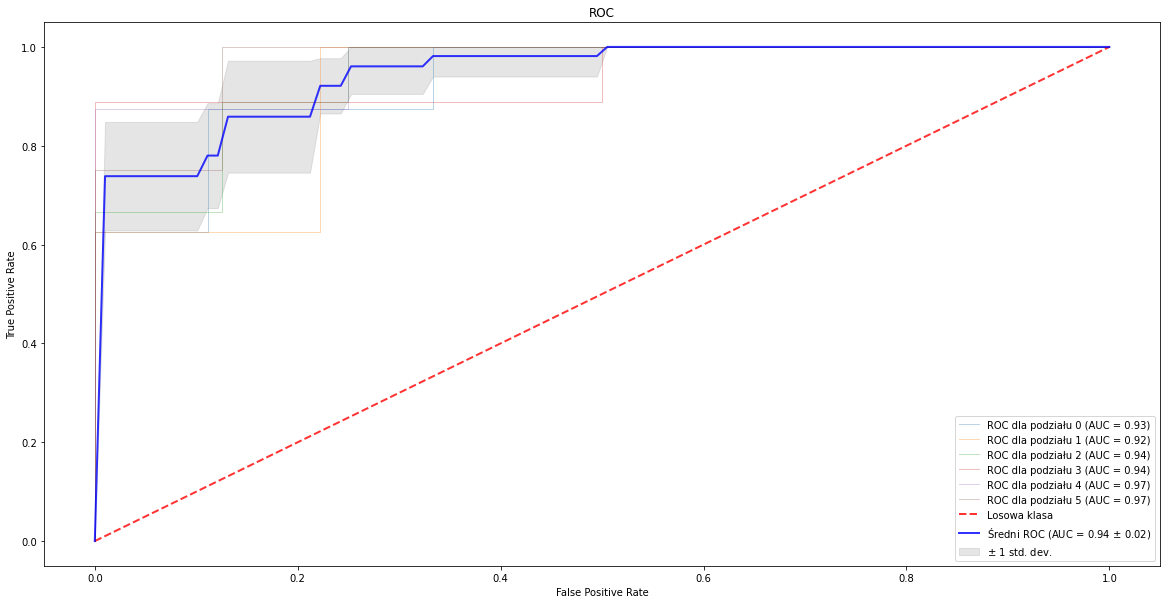

In [14]:
skf  = StratifiedKFold(n_splits=6)
model = LogisticRegression(solver = 'lbfgs')
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# pętla w której dokonujemy walidacji krzyżowej i liczymy krzywe roc
i = 0
for train, test in skf.split(X, Y):
    # fitujemy regresję
    model.fit(X[train], Y[train])
    # obliczamy prawdopodobieństwa przynależności przykładów testowych 
    # do klas wg. wyuczonego klasyfikatora 
    # (zwraca on w danym wierszu prawdopodobieństaw dla każdej z możliwych klas)
    probas_ = model.predict_proba(X[test])  
   
    # Obliczamy punkty krzywej ROC (wykorzystaj odpowiednią funckję z modułu sklearn.metrics)
    fpr, tpr, thresholds = metrics.roc_curve(Y[test], probas_[:, 1]) # względem prawdopodobieństwa klasy 1 
    
    # dostaliśmy pary wartości fpr (oś x) i tpr (oś y), ale te punkty nie są równoodległe
    # chcemy narysować krzywą roc dla punktów z tablicy mean_fpr które są równoodległe
    # za pomocą funkcji np.interp interpoluj wartości krzywej w punktach mean_fpr i dodaj je do tablicy tprs
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    
    # ten punkt ustalamy, żeby krzywa zaczynała się w punkcie (0.0, 0.0), chodzi o estetykę wykresu
    tprs[-1][0] = 0.0
    # obliczamy powierzchnię pod krzywą (wykorzystaj odpowiednią funckję z modułu sklearn.metrics)
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    # rysujemy krzywą 
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC dla podziału %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
    
    
    
# narysuj prostą odpowiadającą klasyfikatorowi losowemu = rzutowi monetą (podpowiedź: chodzi o diagonalę)  
# niech prosta będzie rysowana przerywaną linią o grubości dwa i w kolorze czerwonym
plt.plot([0, 1], [0, 1], linestyle='--', lw = 2, color='r',
         label = 'Losowa klasa', alpha = 0.8)
      
########################################
# poniżej podsumowanie: oliczanie średnich i standardowych odchyleń, cieniowanie przedziału ufności 
########################################
# policz średnie tpr po wszystkich klasach
mean_tpr = np.mean(tprs, axis=0)
# znów estetyka
mean_tpr[-1] = 1.0
# policz średnia auc korzystając z tablic mean_fpr i mean_tpr
mean_auc = metrics.auc(mean_fpr, mean_tpr)
# policz standardowe odchylenie danych w tablicy aucs
std_auc = np.std(aucs)

# proszę narysować krzywą ROC dla danych w mean_fpr i mean_tpr. Krzywa ma mieć grubość 2, kolor niebieski i 
# następującą etykietę:     r'Średni ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Średni ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

# policz odchylenie dla tprs
std_tpr = np.std(tprs, axis=0)
# poniższy kod zwróci nam przedział ufności 68% wokół średniej ROC (1 sigma)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# użyj funkcji fill_between żeby zacieniować obszar między tprs_upper i tprs_lower na szaro z parametrem alpha=0.2
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

# estetyka
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

Sprawdźmy jak miary jakości od rozmiaru zbioru uczącego:

<ipython-input-3-aa6fb8a36dde>:3: DeprecationWarning: scipy.diag is deprecated and will be removed in SciPy 2.0.0, use numpy.diag instead
  cov = [diag([3,3]), diag([4,1.7])] #macierze kowariancji dla klas
<ipython-input-3-aa6fb8a36dde>:3: DeprecationWarning: scipy.diag is deprecated and will be removed in SciPy 2.0.0, use numpy.diag instead
  cov = [diag([3,3]), diag([4,1.7])] #macierze kowariancji dla klas
<ipython-input-3-aa6fb8a36dde>:3: DeprecationWarning: scipy.diag is deprecated and will be removed in SciPy 2.0.0, use numpy.diag instead
  cov = [diag([3,3]), diag([4,1.7])] #macierze kowariancji dla klas
<ipython-input-3-aa6fb8a36dde>:3: DeprecationWarning: scipy.diag is deprecated and will be removed in SciPy 2.0.0, use numpy.diag instead
  cov = [diag([3,3]), diag([4,1.7])] #macierze kowariancji dla klas
<ipython-input-3-aa6fb8a36dde>:3: DeprecationWarning: scipy.diag is deprecated and will be removed in SciPy 2.0.0, use numpy.diag instead
  cov = [diag([3,3]), diag([4,1.7])] #

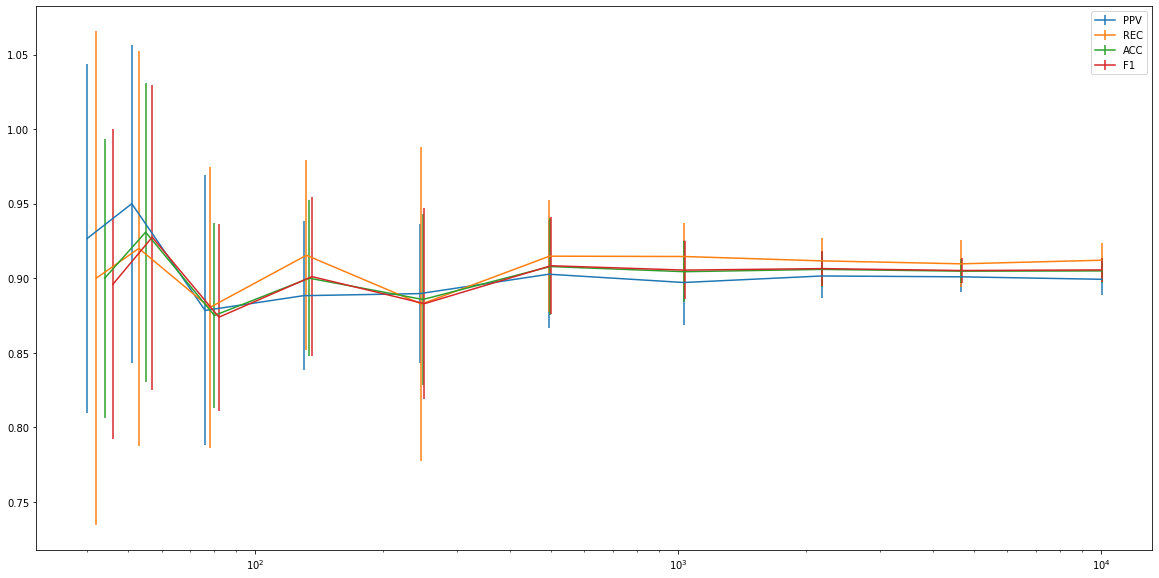

In [15]:
# przygotowujemy tablicę na wartości miar
N = 10
PPV_mean = np.zeros((N,1))
PPV_std = np.zeros((N,1))
REC_mean = np.zeros((N,1))
REC_std = np.zeros((N,1))
ACC_mean = np.zeros((N,1))
ACC_std = np.zeros((N,1))
F1_mean = np.zeros((N,1))
F1_std = np.zeros((N,1))

# ta tablica będzie nam mówić ile danych wygenerować w każdej iteracji  poniższej pętli
n = 30 + np.floor(np.logspace(1,4,N)).astype(int)

for i in range(N):
    # wygeneruj dane używając wcześniej zdefiniowanej funkcji i tablicy n
    X,Y = gen(int(n[i]))
    lr = LogisticRegression(solver = 'lbfgs')
    # policz miary jakości, średnie i odchylenia
    ppv = cross_val_score(lr, X, Y, cv=10, scoring='precision')
    PPV_mean[i] = ppv.mean()
    PPV_std[i]  = ppv.std()
    rec = cross_val_score(lr, X, Y, cv=10, scoring='recall')
    REC_mean[i]  = rec.mean()
    REC_std[i]  = rec.std()
    acc = cross_val_score(lr, X, Y, cv=10, scoring='accuracy')
    ACC_mean[i]  = acc.mean()
    ACC_std[i]  = acc.std()
    f1 = cross_val_score(lr, X, Y, cv=10, scoring='f1')
    F1_mean[i]  = f1.mean()
    F1_std[i]  = f1.std()

# wykres ze słupkami błędów, na osi OX mamy liczebność zbioru, na osi OY wartość miary z niepewnością
ax = plt.subplot(1,1,1)
ppv_plot = plt.errorbar(n, PPV_mean, yerr = PPV_std.ravel())
# uzupełnij wg powyższego przykładu
rec_plot = plt.errorbar(n+2, REC_mean, yerr = REC_std.ravel())
acc_plot = plt.errorbar(n+4, ACC_mean, yerr = ACC_std.ravel())
f1_plot = plt.errorbar(n+6, F1_mean, yerr = F1_std.ravel())
plt.legend(('PPV','REC','ACC','F1'))
ax.set_xscale("log", nonposx='clip')
plt.show()

Widzimy, że im większa liczebność zbioru uczącego tym mniejszy błąd statystyczny używanych miar.

# Klasy niezrównoważone

Wytwórzymy teraz dane, w których jedna z klas jest M-krotnie liczniejsza. 

In [16]:
def gen_rozne(ile, M):
    mu = [(-1,0.5),(1,4)]
    #mu = [(-1,0.5),(-1,0.5)]
    # macierz kowariancji
    cov = [diag([1.7,1.8]), diag([1.5,0.7])]
    X = np.zeros(((M+1)*ile, 2)) # miejsce na dane wejściowe
    Y = np.zeros(((M+1)*ile, 1),dtype = int) # miejsce na dane wyjściowe
    print(Y.shape)
    klasa = 0
    # wygeneruj dane w X z rozkładu normalnego wielowymiarowego z odp. parametrami dla klasy 0
    X[0:ile] = np.random.multivariate_normal(mu[klasa],cov[klasa],ile)
    Y[0:ile] = klasa
    klasa = 1 
    # wygeneruj dane w X z rozkładu normalnego wielowymiarowego z odp. parametrami dla klasy 1
    X[ile:ile+ile*M] = np.random.multivariate_normal(mu[klasa],cov[klasa],ile*M)
    Y[ile:ile+ile*M] = klasa
    Y = Y.ravel()
    print(np.sum(Y==0), np.sum(Y==1) )
    return (X,Y)

Oglądamy dane:

<ipython-input-16-5685d9a6a4e0>:5: DeprecationWarning: scipy.diag is deprecated and will be removed in SciPy 2.0.0, use numpy.diag instead
  cov = [diag([1.7,1.8]), diag([1.5,0.7])]


(3030, 1)
30 3000


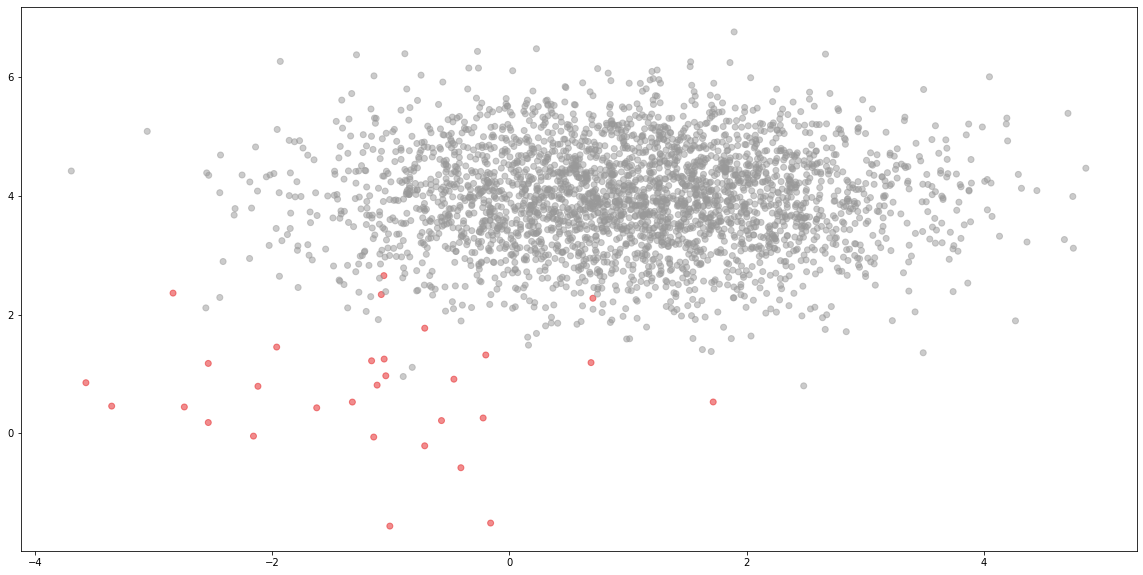

In [17]:
X,Y = gen_rozne(30, 100)
plt.scatter(X[:,0], X[:,1] ,c = Y, cmap=plt.cm.Set1, alpha = 0.5)
plt.show()

Obliczamy miary jakości dla danych niezrównoważonych przy podziale 10-krotnym. Zwróćmy uwagę na różnicę w wartościach 4 pierwszych miar i miary MCC:

In [18]:
ppv = cross_val_score(model, X, Y, cv=10, scoring='precision')
print('PPV = {0:.2f} +/- {1:.2f}'.format(ppv.mean(),ppv.std()))
rec = cross_val_score(model, X, Y, cv=10, scoring='recall')
print('REC = {0:.2f} +/- {1:.2f}'.format(rec.mean(),rec.std()))
acc = cross_val_score(model, X, Y, cv=10, scoring='accuracy')
print('ACC = {0:.2f} +/- {1:.2f}'.format(acc.mean(),acc.std()))
f1 = cross_val_score(model, X, Y, cv=10, scoring='f1')
print('F1 = {0:.2f} +/- {1:.2f}'.format(f1.mean(),f1.std()))
print('-----')

# MCC policzymy w pętli
MCC=np.zeros((10,1))
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1) # test na 10% aby było podobnie jak dla podziału 10-krotnego
    # trenuj model
    model.fit(X_train, y_train) 
    # predykcja dla zbioru testowego
    y_pred = model.predict(X_test) 
    # policz MCC korzystając z odpowiedniej funkcji
    MCC[i] = metrics.matthews_corrcoef(y_test, y_pred)
    
    zeros = 0
    ones = 0
    # policz ile jest reprezentantów klasy 0 i klasy 1 w tablicy y_train i wpisz w powyższe zmienne
    # MIEJSCE NA TWÓJ KOD
    for j in range(len(y_train)):
      if y_train[j] == 0:
        zeros +=1
      else:
        ones += 1
    # wypisujemy liczebność klas w zbiorze uczącym, wykonaj kilka razy i zaobserwuj jak się zachowuje MCC a jak inne miary 
    print(zeros, ones)
    
    
print('MCC = {0:.2f} +/- {1:.2f}'.format(MCC.mean(),MCC.std()))  
   

PPV = 1.00 +/- 0.00
REC = 1.00 +/- 0.00
ACC = 1.00 +/- 0.00
F1 = 1.00 +/- 0.00
-----
30 2697
25 2702
26 2701
27 2700
25 2702
28 2699
23 2704
27 2700
27 2700
26 2701
MCC = 0.77 +/- 0.32


/Users/rafalmaselek/Library/Python/3.8/lib/python/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Teraz spróbujemy zobaczyć czy da się to poprawić, jeśli w podziałach zadbać o zachowanie proporcji klas. Można to łatwo zrobić za pomocą funkcji `StratifiedKFold`, zwraca ona indeksy do zbioru treningowego i testowego:

In [19]:
skf = StratifiedKFold(n_splits = 4)
for train, test in skf.split(X, Y):
    zeros = 0
    ones = 0
    # ponownie policz ile jest reprezentatnów poszczególnych klas w 
    # zbiorze uczącym i wpisz wartości w powyższe zmienne
    # podpowiedź: wykorzystaj zmienną train aby dostać się do podzbioru danych uczących
    for i in range(len(Y[train])):
      if Y[train][i] == 0:
        zeros +=1
      else:
        ones += 1

    print(zeros, ones, len(Y[train]))
    # fituj model dla danego podzbioru uczącego
    model.fit(X[train,:],Y[train])
    # wykonaj predykcję dla danego podzbioru uczącego
    y_pred = model.predict(X[test,:]) 
    # odczytaj etykiety klas podzbioru uczącego
    y_test = Y[test]
    # policz miary jakości
    PPV = metrics.precision_score(y_test, y_pred)
    REC = metrics.recall_score(y_test, y_pred)
    ACC = metrics.accuracy_score(y_test, y_pred)
    F1 = metrics.f1_score(y_test,  y_pred)
    MCC = metrics.matthews_corrcoef(y_test, y_pred)
    
    print('PPV = {p:.3f} REC = {r:.3f} ACC = {a:.3f} F1 = {f:.3f} MCC =  {m:.3f}  '.format(a=ACC,f=F1,m=MCC,p=PPV,r=REC))

22 2250 2272
PPV = 0.999 REC = 0.999 ACC = 0.997 F1 = 0.999 MCC =  0.874  
22 2250 2272
PPV = 0.997 REC = 1.000 ACC = 0.997 F1 = 0.999 MCC =  0.865  
23 2250 2273
PPV = 0.997 REC = 1.000 ACC = 0.997 F1 = 0.999 MCC =  0.844  
23 2250 2273
PPV = 0.996 REC = 0.999 ACC = 0.995 F1 = 0.997 MCC =  0.674  


Zbadajmy jeszcze krzywą ROC:

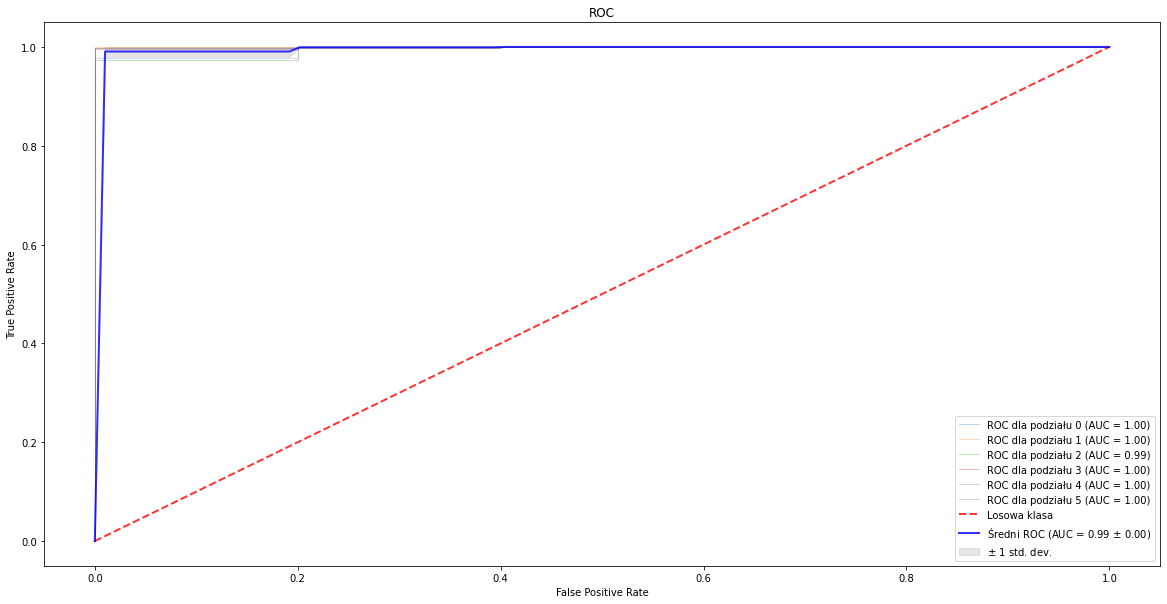

In [20]:
skf  = StratifiedKFold(n_splits=6)
model = LogisticRegression(solver = 'lbfgs')
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in skf.split(X, Y):
    # fitujemy regresję
    model.fit(X_train, y_train) 
    # obliczamy prawdopodobieństwa przynależności przykładów testowych 
    # do klas wg. wyuczonego klasyfikatora 
    # (zwraca on w danym wierszu prawdopodobieństaw dla każdej z możliwych klas)
    probas_ = model.predict_proba(X[test])  
   
    # Obliczamy punkty krzywej ROC 
    fpr, tpr, thresholds = metrics.roc_curve(Y[test], probas_[:, 1]) # względem prawdopodobieństwa klasy 1 
    # interpoluj wartości TPR dla mean_fpr, jak poprzednio   
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    # estetyka
    tprs[-1][0] = 0.0
    # policz powierzchnię pod krzywą
    roc_auc = metrics.auc(fpr, tpr)
    aucs.append(roc_auc)
    # rysujemy krzywą 
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC dla podziału %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
    
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Losowa klasa', alpha=.8)
         
########################################
# poniżej podsumowanie: oliczanie średnich i standardowych odchyleń, cieniowanie przedziału ufności 
########################################
# policz średnie tpr po wszystkich klasach
mean_tpr = np.mean(tprs, axis=0)
# znów estetyka
mean_tpr[-1] = 1.0
# policz średnia auc korzystając z tablic mean_fpr i mean_tpr
mean_auc = metrics.auc(mean_fpr, mean_tpr)
# policz standardowe odchylenie danych w tablicy aucs
std_auc = np.std(aucs)

# proszę narysować krzywą ROC dla danych w mean_fpr i mean_tpr. Krzywa ma mieć grubość 2, kolor niebieski i 
# następującą etykietę:     r'Średni ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Średni ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

# policz odchylenie dla tprs
std_tpr = np.std(tprs, axis=0)
# poniższy kod zwróci nam przedział ufności 68% wokół średniej ROC (1 sigma)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
# użyj funkcji fill_between żeby zacieniować obszar między tprs_upper i tprs_lower na szaro z parametrem alpha=0.2
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

# estetyka
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

Powyższe obliczenia obliczenia proszę przeprowadzić dla klas, których rozkłady wyraźnie się różnią i dla takich które się pokrywają w znacznym stopniu. Trzeba podmienić średnie klas w funkcji generującej dane różnoliczne.

# Jakie stąd płyną wnioski?


Wyobraź sobie, że jesteś na egzaminie i w oparciu o dzisiejsze ćwiczenie dostajesz kilka pytań. Czy umiesz odpowiedzieć wyczerpująco i ze zrozumieniem na wszystkie?

1) Jakie płyną konsekwencje z dużej różnicy częstości występowania dwóch klas?

2) Które miary jakości są na ten efekt najmniej i najbardziej wrażliwe?

3) Jak można przeciwdziałać efektowi częstości występowania?

4) Czy efekt częstości występowania ma taki sam czy różny wpływ na miary jakości w przypadku, gdy klasy pochodzą z rozkładów, które się znacząco pokrywają lub są mocno rozseparowane?